# Welcome to the Calibration Workshop!

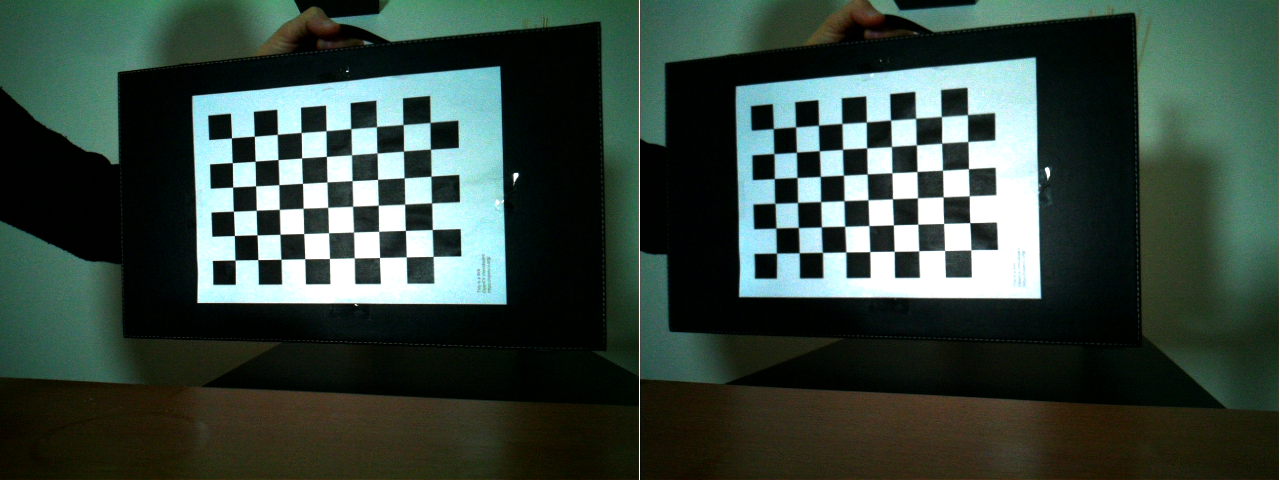

Today, we're going to learn how to calibrate a camera in mono and Stereo modes.

The outputs we're interested in:
*   The Focal length (intrinsic)
*   The Rotation Matrix (extrinsic)
*   The Translation Matrix (extrinsic)
*   The Optical Center (intrinsic)


In [1]:
from utils import extract_from_location, download_and_extract
import os

# Check if zip file exists, download if not
zip_file = "stereo_vision_data.zip"
if not os.path.exists(zip_file):
    print(f"{zip_file} not found. Downloading...")
    download_and_extract("https://stereo-vision.s3.eu-west-3.amazonaws.com/stereo_vision_data.zip")
else:
    print(f"{zip_file} found. Extracting...")
    extract_from_location(zip_file)

stereo_vision_data.zip found. Extracting...
Extracting stereo_vision_data.zip...
Extraction complete to: .


In [2]:
# Dataset already extracted by the previous cell

In [3]:
import os

## Import Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import os

# Step 1 - Mono Camera Calibration

Before going to stereo, it's good we try calibration with a monocular image.

👉 To go insanely faster, just check the OpenCV calibration tutorial and lines of code. Your work will be to understand how to adapt it here.

Open: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html



### First, go to the folder Image Pairs/pairs and only take the left (or the right) images

Found 30 left images


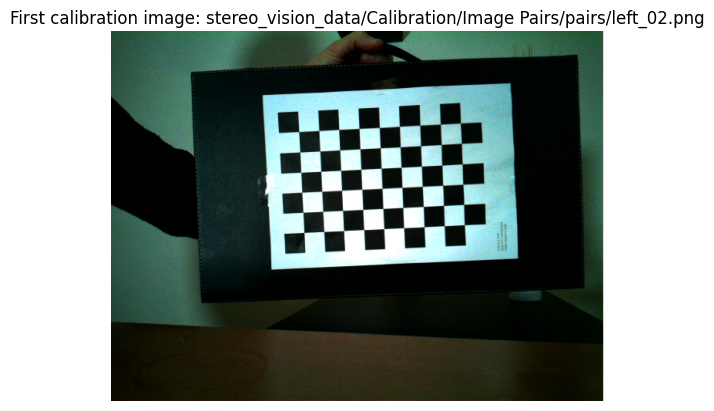

In [5]:
## TODO: Load the Left (or right) Images. You can use the GLOB API.

calibration_images = glob.glob("stereo_vision_data/Calibration/Image Pairs/pairs/left_*.png")
print(f"Found {len(calibration_images)} left images")

## TODO2: Show an image
if calibration_images:
    img = mpimg.imread(calibration_images[0])
    plt.imshow(img)
    plt.title(f"First calibration image: {calibration_images[0]}")
    plt.axis("off")
    plt.show()

Now, we'll need two things:
*   Object Points -- A matrix made of the dimensions of the chessboard with 3D coordinates (0,0,0) (0,1,0) ...
*   Image Points -- A matrix of 2D points with the same dimensions

In [6]:
# TODO: Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
## WARNING - The square size is 2.4 cm on my pictures.
rows = 6
columns = 9
square_size = 24 #expressed in mm

# Create a meshgrid of coordinates
objp = np.zeros((rows * columns, 3), np.float32)
objp[:, :2] = np.mgrid[0:columns, 0:rows].T.reshape(-1, 2)

# Scale by square_size to get actual measurements in mm
objp = objp * square_size

## TYPE OF OUTPUT WE'RE LOOKING FOR:
## [[  0.   0.   0.]
## [ 24.   0.   0.]
## [ 48.   0.   0.]
## ...
## [192. 120.   0.]]

## TODO2: Print the objp matrix and see if you have the same as I have
print(objp)

[[  0.   0.   0.]
 [ 24.   0.   0.]
 [ 48.   0.   0.]
 [ 72.   0.   0.]
 [ 96.   0.   0.]
 [120.   0.   0.]
 [144.   0.   0.]
 [168.   0.   0.]
 [192.   0.   0.]
 [  0.  24.   0.]
 [ 24.  24.   0.]
 [ 48.  24.   0.]
 [ 72.  24.   0.]
 [ 96.  24.   0.]
 [120.  24.   0.]
 [144.  24.   0.]
 [168.  24.   0.]
 [192.  24.   0.]
 [  0.  48.   0.]
 [ 24.  48.   0.]
 [ 48.  48.   0.]
 [ 72.  48.   0.]
 [ 96.  48.   0.]
 [120.  48.   0.]
 [144.  48.   0.]
 [168.  48.   0.]
 [192.  48.   0.]
 [  0.  72.   0.]
 [ 24.  72.   0.]
 [ 48.  72.   0.]
 [ 72.  72.   0.]
 [ 96.  72.   0.]
 [120.  72.   0.]
 [144.  72.   0.]
 [168.  72.   0.]
 [192.  72.   0.]
 [  0.  96.   0.]
 [ 24.  96.   0.]
 [ 48.  96.   0.]
 [ 72.  96.   0.]
 [ 96.  96.   0.]
 [120.  96.   0.]
 [144.  96.   0.]
 [168.  96.   0.]
 [192.  96.   0.]
 [  0. 120.   0.]
 [ 24. 120.   0.]
 [ 48. 120.   0.]
 [ 72. 120.   0.]
 [ 96. 120.   0.]
 [120. 120.   0.]
 [144. 120.   0.]
 [168. 120.   0.]
 [192. 120.   0.]]


Good!

### Time to use those OpenCV functions 😊

The process is the following:

*   Read the images in a loop
*   Convert them to grayscale
*   Find the Chessboard corners using the cv2.findChessboardCorners function
*   (Optional) Use cornerSubPix for petter precision
*   Draw the Chessboard corners and display all of them to check if your calibration was successful
*   Return the object points and the image points

In [7]:
# TODO: Define a get_points function that will do calibration.

def get_points(calibration_images, objp, rows=6, columns=9):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(calibration_images):
        image = cv2.imread(fname)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (columns, rows), None)

        if ret==True:
            # If found, add object points, image points. Draw the corners and visualize them
            objpoints.append(objp)
            
            # Refine corner positions for better accuracy
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
            
            # Draw and display the corners
            cv2.drawChessboardCorners(image, (columns, rows), corners2, ret)
            cv2.imshow('Chessboard Corners', image)
            cv2.waitKey(500)
    
    return objpoints, imgpoints

###Now, define a function that will send your defined object point matrix and the images and return the filled matrices 3D/2D matrices.

**Print the results to see if it makes sense.**

In [8]:
## TODO: Call the get_points function
objpoints, imgpoints =get_points(calibration_images, objp, rows=6, columns=9)

## Print an example
print("An example of an object point (top-left corner) and its corresponding image point")
print(objpoints[0][0])
print(imgpoints[0][0])
cv2.destroyAllWindows()

An example of an object point (top-left corner) and its corresponding image point
[0. 0. 0.]
[[243.8612  130.59435]]


### Finally, call the cv2.calibrateCamera function and print the parameters.

In [9]:
# TODO: Call the calibrateCamera function
## Be sure to check the OpenCV documentation: https://docs.opencv.org/4.1.2/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d

img_shape = (640,480)
flags = cv2.CALIB_FIX_K1 | cv2.CALIB_FIX_K2 | cv2.CALIB_FIX_K3
ret, mtx, dist, rvecs, tvecs =cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None, flags=flags)


print("-- Camera Parameters --")
print("Root Mean Squared Error (between 0.1 and 1)")
print(ret)
print("")
print("Camera Matrix")
print(mtx)
print("")
print("Distorion Coefficients Matrix")
print(dist)
print("")
print("Rotation Vector")
print(rvecs)
print("")
print("Translation Vector")
print(tvecs)

-- Camera Parameters --
Root Mean Squared Error (between 0.1 and 1)
0.21969760584354395

Camera Matrix
[[556.63163458   0.         328.20069151]
 [  0.         557.04700491 240.15096795]
 [  0.           0.           1.        ]]

Distorion Coefficients Matrix
[[ 0.          0.         -0.00648891  0.01113194  0.        ]]

Rotation Vector
(array([[ 0.02463077],
       [-0.00278412],
       [-0.04828959]]), array([[-0.07399373],
       [ 0.09735558],
       [ 0.18354272]]), array([[ 0.08597221],
       [ 0.02420609],
       [-0.06628957]]), array([[ 0.04144332],
       [ 0.35686683],
       [-0.03973201]]), array([[-0.07759687],
       [ 0.12122024],
       [-0.3278035 ]]), array([[ 0.00941265],
       [ 0.23857658],
       [-0.02721107]]), array([[-0.00424014],
       [-0.27333335],
       [-0.09536308]]), array([[-0.03505359],
       [ 0.31033358],
       [-0.06426654]]), array([[-0.0098615 ],
       [ 0.14602661],
       [-0.02321191]]), array([[-0.41773486],
       [ 0.18506207],
 

###Undistort the image using cv2.undistort()

*   Is the result good?
*   If not, how can you make it better?


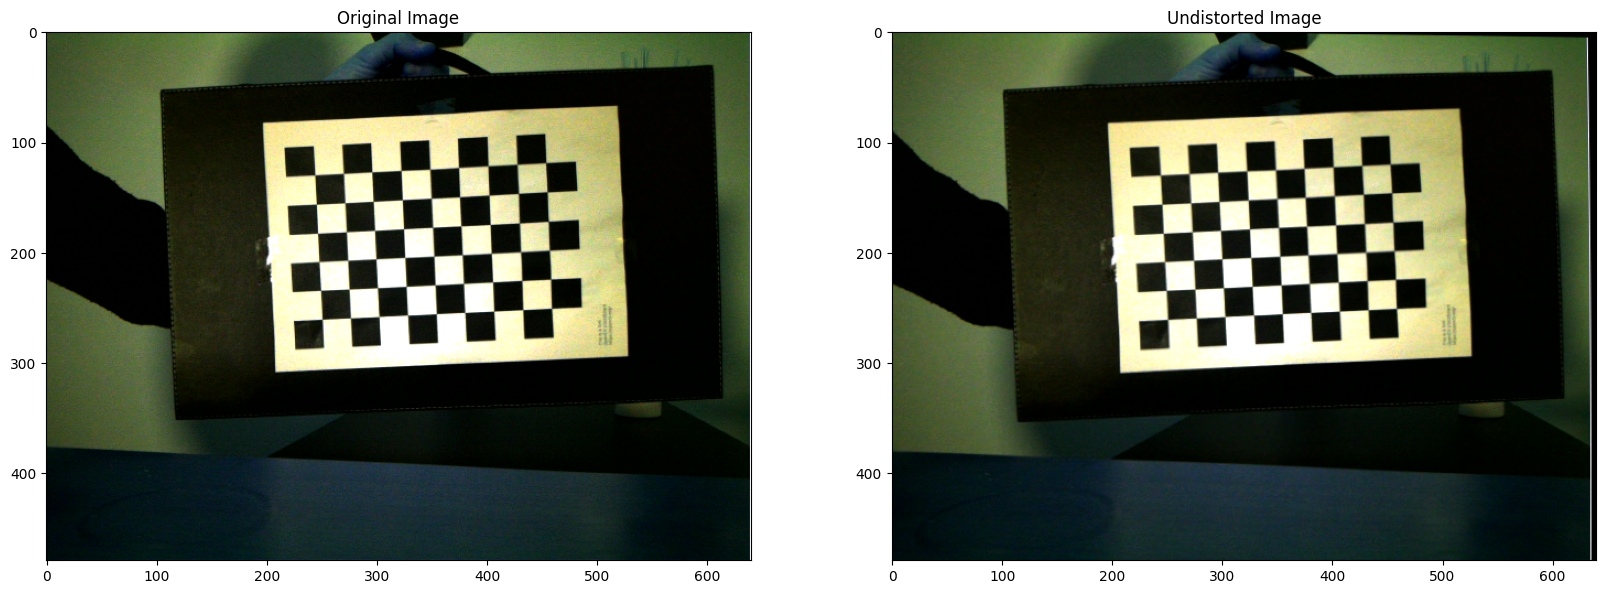

In [10]:
#TODO: Undistort the image
img =cv2.imread(calibration_images[0])
undistorted =cv2.undistort(img, mtx, dist, None)

## TODO2: Display the image before and after distortion
f, (ax0, ax1) = plt.subplots(1,2,figsize=(20,10))
ax0.imshow(img)
ax0.set_title("Original Image")
ax1.imshow(undistorted)
ax1.set_title("Undistorted Image")
plt.show()

# Step 2 - Stereo Camera Calibration

We are now ready for stereo calibration.
The output we'll get:


*   Intrinsic and Extrinsic parameters for both cameras

You will also get some parameters we'll use for Depth Perception.

*   Disparity to Depth Map
*   Fundamental And Essential Matrices
*   Projection Matrix
*   Other matrices

These will be explained in Part III - Building a 3D System

## Install Stereo Vision Library and Import some we'll need

In [11]:
!pip3 install stereovision

In [12]:
from stereovision.calibration import StereoCalibrator
from stereovision.calibration import StereoCalibration
from stereovision.exceptions import ChessboardNotFoundError

## Follow the code from the MIPI Camera Software


*   Calibration: https://github.com/erget/StereoVision/blob/master/stereovision/calibration.py
*   Script in the Raspberry Pi: https://github.com/ArduCAM/MIPI_Camera/blob/master/RPI/stereo_depth_demo/4_calibration.py



In [15]:
## These have been defined earlier.
img_shape = (640,480)
rows = 6
columns = 9
square_size = 2.4

# TODO: Call the Stereo Calibrator Object
calibrator = StereoCalibrator(rows, columns, square_size,img_shape)

# Define an empty counter and your number of images
counter = 0
total_photos= 30

# Call the get_corners function
# Warning, on Colab, it's better not to use cv2.imshow(). Therefore, set the last parameter for add_corners as False

while counter != total_photos:
    counter += 1
    print ('Import pair No ' + str(counter))
    leftName = 'stereo_vision_data/Calibration/Image Pairs/pairs/left_'+str(counter).zfill(2)+'.png'
    rightName = 'stereo_vision_data/Calibration/Image Pairs/pairs/right_'+str(counter).zfill(2)+'.png'
    imgLeft = cv2.imread(leftName,1)
    imgRight = cv2.imread(rightName,1)
    if os.path.isfile(leftName) and os.path.isfile(rightName):
        #TODO: Get corners and add them to the calibrator object
        calibrator.add_corners((imgLeft, imgRight), show_results=False)
print ('End cycle')

Import pair No 1
Import pair No 2
Import pair No 3
Import pair No 4
Import pair No 5
Import pair No 6
Import pair No 7
Import pair No 8
Import pair No 9
Import pair No 10
Import pair No 11
Import pair No 12
Import pair No 13
Import pair No 14
Import pair No 15
Import pair No 16
Import pair No 17
Import pair No 18
Import pair No 19
Import pair No 20
Import pair No 21
Import pair No 22
Import pair No 23
Import pair No 24
Import pair No 25
Import pair No 26
Import pair No 27
Import pair No 28
Import pair No 29
Import pair No 30
End cycle


### Great! Now, let's calibrate the cameras

In [16]:
# TODO: Call Calibrate_cameras() and print the results
print ('Starting calibration... It can take several minutes!')
calibration = calibrator.calibrate_cameras()
print ('Calibration complete!')

print(calibration)

Starting calibration... It can take several minutes!
Calibration complete!
cam_mats:
{'left': array([[557.32266985,   0.        , 313.5664134 ],
       [  0.        , 557.32266985, 245.90212561],
       [  0.        ,   0.        ,   1.        ]]), 'right': array([[557.32266985,   0.        , 314.87432671],
       [  0.        , 557.32266985, 239.53007113],
       [  0.        ,   0.        ,   1.        ]])}
dist_coefs:
{'left': array([[-0.01822514,  1.1208881 ,  0.        ,  0.        , -6.43280469]]), 'right': array([[-0.01539816,  0.40286266,  0.        ,  0.        , -2.15903971]])}
rot_mat:
[[ 0.99950695 -0.00262216 -0.03128877]
 [ 0.00257995  0.99999571 -0.00138907]
 [ 0.03129228  0.00130766  0.99950942]]
trans_vec:
[[-7.76364713]
 [ 0.0139524 ]
 [-0.86324839]]
e_mat:
[[ 2.66374404e-03  8.63262929e-01  1.27464453e-02]
 [-6.19880555e-01  1.24157930e-02  7.78684844e+00]
 [-3.39753796e-02 -7.76357722e+00  1.12208013e-02]]
f_mat:
[[ 5.03287150e-08  1.63104688e-05 -3.89233974e-03]
 [

And now let's save our parameters:

In [17]:
calibration.export('stereo_vision_data/Calibration/Image Pairs/calib_result')

### Now try to undistort the image (with the default parameters)

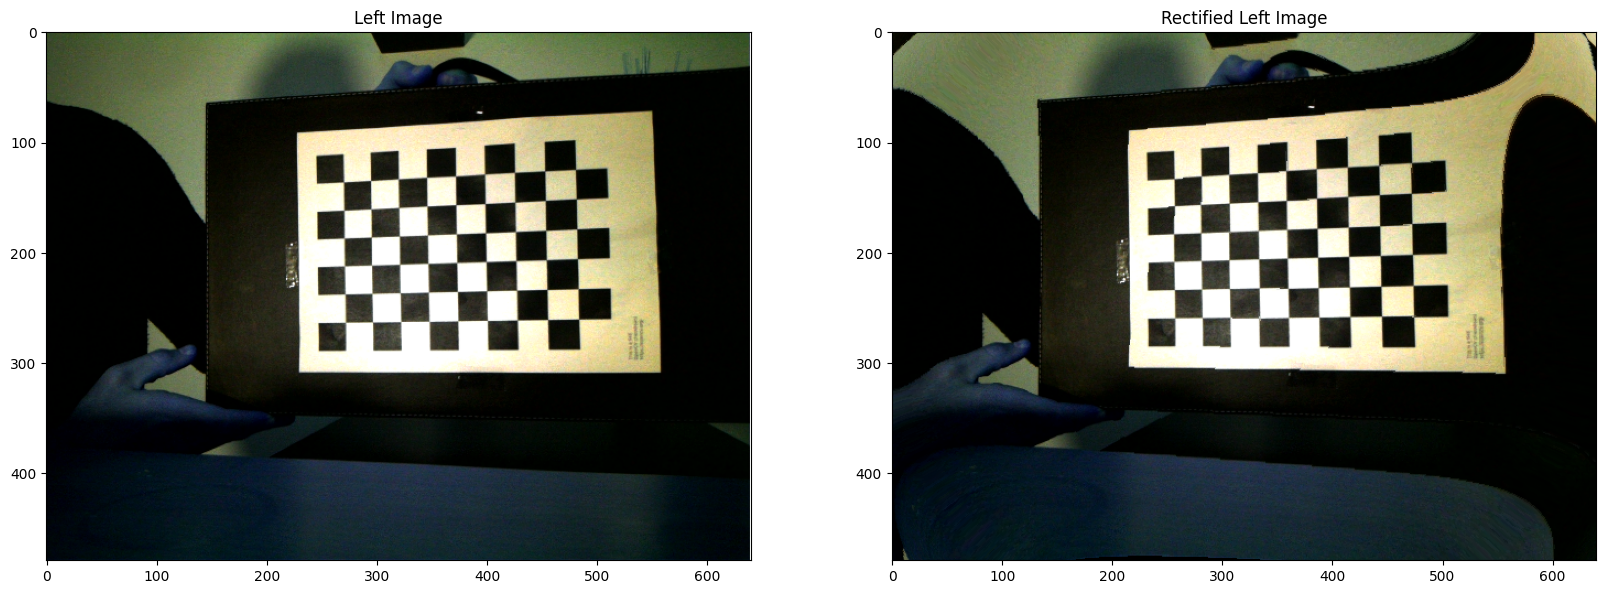

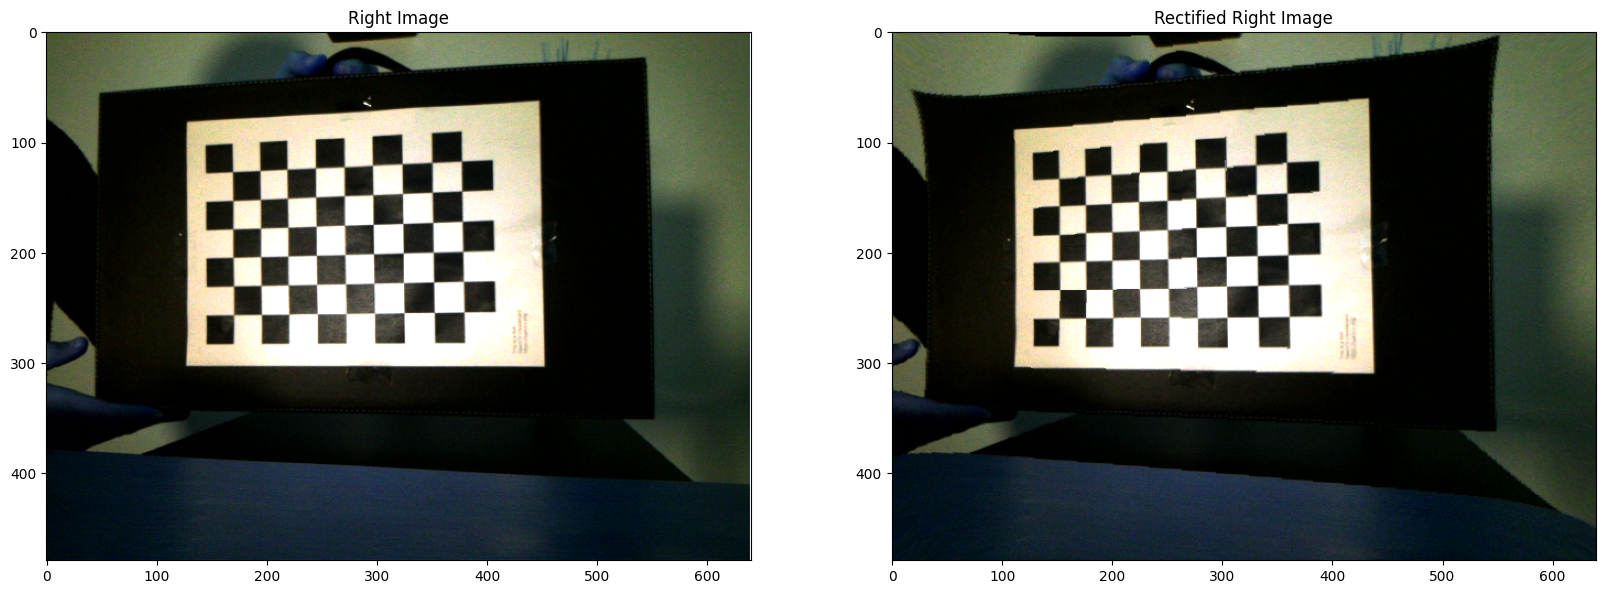

In [18]:
# TODO: Rectify the images
rectified_pair =calibration.rectify((imgLeft, imgRight))

# TODO2: Show the rectified left and right images
f, (ax0, ax1)= plt.subplots(1,2, figsize=(20,10))
ax0.imshow(imgLeft)
ax0.set_title("Left Image")
ax1.imshow(rectified_pair[0])
ax1.set_title("Rectified Left Image")
plt.show()
f, (ax2, ax3)= plt.subplots(1,2, figsize=(20,10))
ax2.imshow(imgRight)
ax2.set_title("Right Image")
ax3.imshow(rectified_pair[1])
ax3.set_title("Rectified Right Image")
plt.show()

### 😕😕😕 We need to use the Flags; but they're inside the function and cannot be changed; as you can see here: https://github.com/erget/StereoVision/blob/f09d67140e8164969ae3458fc4df658fbbf3649b/stereovision/calibration.py#L218

In [19]:
## TODO: Rewrite the calibrate_cameras function with the desired FLAGS
## Watch this: https://docs.opencv.org/4.1.2/d9/d0c/group__calib3d.html#ga91018d80e2a93ade37539f01e6f07de5 and choose YOUR openCV version

#print(cv2.__version__) # to know your version

def calibrate_cameras(calibrator):
        """Calibrate cameras based on found chessboard corners."""
        criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)

        flags = cv2.CALIB_FIX_K1 | cv2.CALIB_FIX_K2 | cv2.CALIB_FIX_K3 #TODO: Pick your flags

        calib = StereoCalibration()
        # MAKE SURE THE FUNCTION CALL IS CORRECT
        (retval, calib.cam_mats["left"], calib.dist_coefs["left"], calib.cam_mats["right"], calib.dist_coefs["right"],
        calib.rot_mat, calib.trans_vec, calib.e_mat, calib.f_mat) = cv2.stereoCalibrate(calibrator.object_points,
                                            calibrator.image_points["left"],
                                            calibrator.image_points["right"],calib.cam_mats["left"],
                                            calib.dist_coefs["left"],
                                            calib.cam_mats["right"],
                                            calib.dist_coefs["right"],calibrator.image_size,calib.rot_mat,
                                            calib.trans_vec,
                                            calib.e_mat,
                                            calib.f_mat,
                                            flags, criteria)

        (calib.rect_trans["left"], calib.rect_trans["right"],
         calib.proj_mats["left"], calib.proj_mats["right"],
         calib.disp_to_depth_mat, calib.valid_boxes["left"],
         calib.valid_boxes["right"]) = cv2.stereoRectify(calib.cam_mats["left"],
                                                      calib.dist_coefs["left"],
                                                      calib.cam_mats["right"],
                                                      calib.dist_coefs["right"],
                                                      calibrator.image_size,
                                                      calib.rot_mat,
                                                      calib.trans_vec,
                                                      flags=0)
        for side in ("left", "right"):
            (calib.undistortion_map[side],
             calib.rectification_map[side]) = cv2.initUndistortRectifyMap(
                                                        calib.cam_mats[side],
                                                        calib.dist_coefs[side],
                                                        calib.rect_trans[side],
                                                        calib.proj_mats[side],
                                                        calibrator.image_size,
                                                        cv2.CV_32FC1)
        # This is replaced because my results were always bad. Estimates are
        # taken from the OpenCV samples.
        width, height = calibrator.image_size
        focal_length = 0.8 * width
        calib.disp_to_depth_mat = np.float32([[1, 0, 0, -0.5 * width],
                                              [0, -1, 0, 0.5 * height],
                                              [0, 0, 0, -focal_length],
                                              [0, 0, 1, 0]])
        return calib

In [20]:
## TODO: Calibrate again, and compare
print ('Starting calibration... It can take several minutes!')
result_calib = calibrate_cameras(calibrator)
print ('Calibration complete!')

print(result_calib)

Starting calibration... It can take several minutes!
Calibration complete!
cam_mats:
{'left': array([[557.40297082,   0.        , 328.13997203],
       [  0.        , 557.79913246, 240.06799057],
       [  0.        ,   0.        ,   1.        ]]), 'right': array([[571.26362065,   0.        , 323.42006707],
       [  0.        , 571.24726526, 230.31835475],
       [  0.        ,   0.        ,   1.        ]])}
dist_coefs:
{'left': array([[ 0.        ,  0.        , -0.00644753,  0.01126532,  0.        ]]), 'right': array([[ 0.        ,  0.        , -0.00292378,  0.00841354,  0.        ]])}
rot_mat:
[[ 0.99983266 -0.00217925 -0.01816327]
 [ 0.0022767   0.99998312  0.00534609]
 [ 0.01815132 -0.00538655  0.99982074]]
trans_vec:
[[-7.86090291]
 [-0.02984446]
 [ 0.12277275]]
e_mat:
[[-8.21232354e-04 -1.22609917e-01 -3.04954631e-02]
 [ 2.65437935e-01 -4.26107165e-02  7.85726382e+00]
 [ 1.19425816e-02 -7.86083524e+00 -4.25672038e-02]]
f_mat:
[[-1.23769504e-08 -1.84656519e-06  1.91178503e-04]
 [

### Finally, let's rectify again

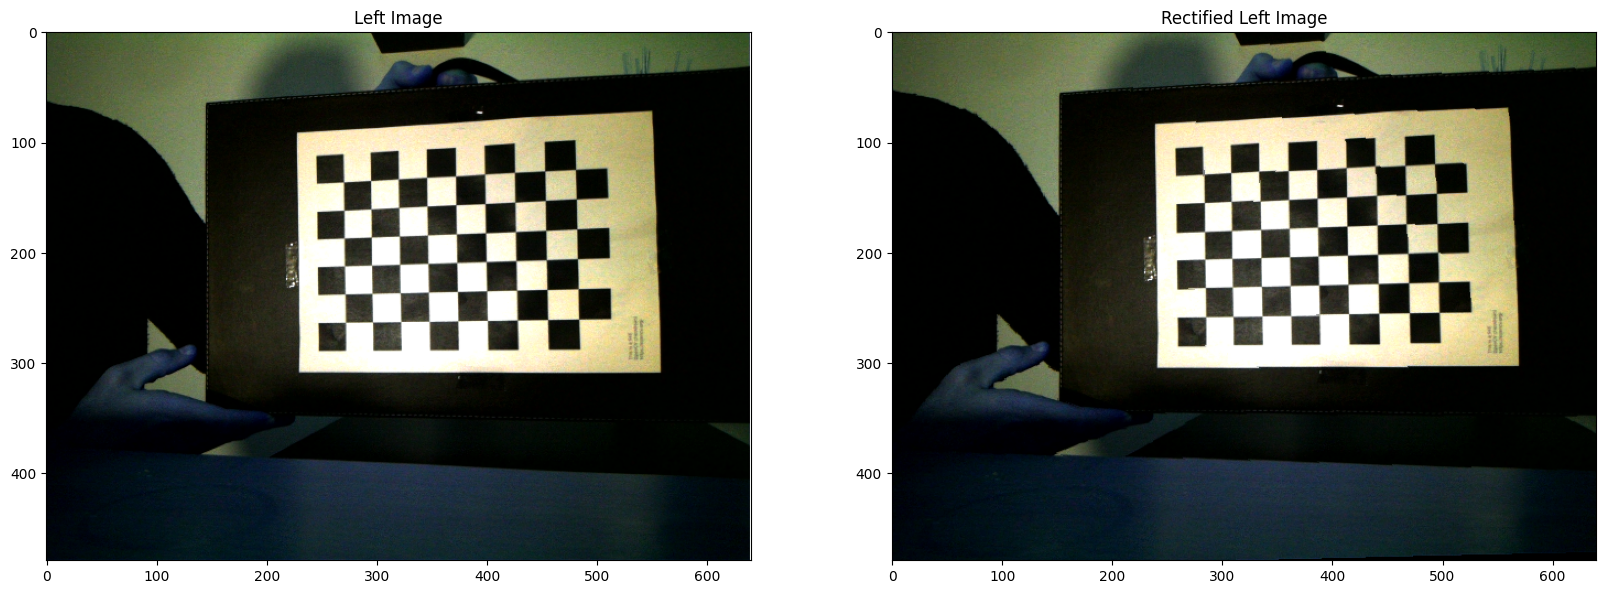

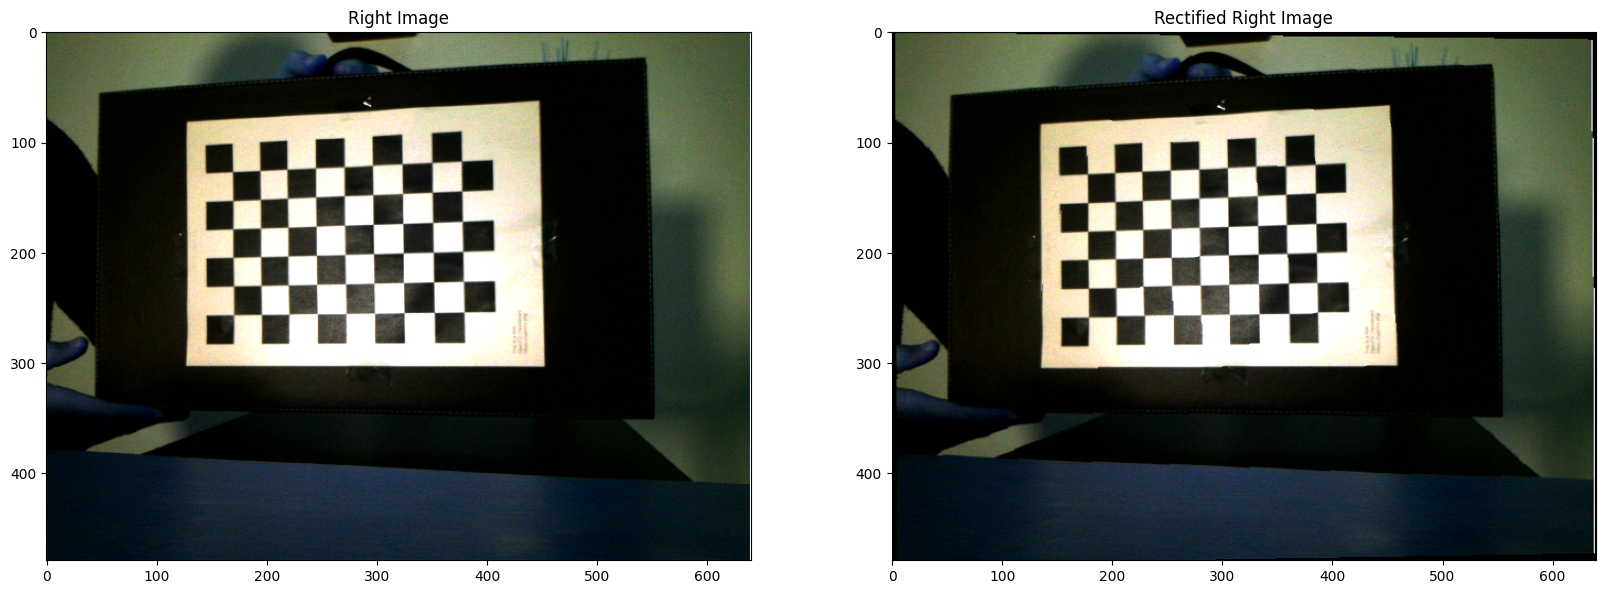

In [21]:
# TODO: Rectify the images
rectified_pair = result_calib.rectify((imgLeft, imgRight))

# TODO2: Show the rectified left and right images
f, (ax0, ax1)= plt.subplots(1,2, figsize=(20,10))
ax0.imshow(imgLeft)
ax0.set_title("Left Image")
ax1.imshow(rectified_pair[0])
ax1.set_title("Rectified Left Image")
plt.show()
f, (ax2, ax3)= plt.subplots(1,2, figsize=(20,10))
ax2.imshow(imgRight)
ax2.set_title("Right Image")
ax3.imshow(rectified_pair[1])
ax3.set_title("Rectified Right Image")
plt.show()

# Calibration parameters obtained using the MIPI Camera Software

In [24]:
f_mat = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/f_mat.npy")
e_mat = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/e_mat.npy")
cam_mats_right = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/cam_mats_right.npy")
cam_mats_left = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/cam_mats_left.npy")
disp_to_depth_mat = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/disp_to_depth_mat.npy")
dist_coefs_left = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/dist_coefs_left.npy")
dist_coefs_right = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/dist_coefs_right.npy")
proj_mats_left = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/proj_mats_left.npy")
proj_mats_right = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/proj_mats_right.npy")
rect_trans_left = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/rect_trans_left.npy")
rect_trans_right = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/rect_trans_right.npy")
rectification_map_left = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/rectification_map_left.npy")
rectification_map_right = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/rectification_map_right.npy")
rot_mat = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/rot_mat.npy")
trans_vec = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/trans_vec.npy")
undistortion_map_left = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/undistortion_map_left.npy")
undistortion_map_right = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/undistortion_map_right.npy")
valid_boxes_left = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/valid_boxes_left.npy")
valid_boxes_right = np.load("stereo_vision_data/Calibration/Image Pairs/calib_result/valid_boxes_right.npy")

print("Fundamental Matrix")
print(f_mat)
print("Essential Matrix")
print(e_mat)
print("Camera Matrix Left/Right")
print(cam_mats_left)
print(cam_mats_right)
print("Rotation Matrix")
print(rot_mat)
print("Translation Vector")
print(trans_vec)
print("Disparity to Depth Matrix")
print(disp_to_depth_mat)
print("Distortion Coefficients Left/Right")
print(dist_coefs_left)
print(dist_coefs_right)
print("Projection Matrix Left/Right")
print(proj_mats_left)
print(proj_mats_right)
print("Rectification Translation Left/Right")
print(rect_trans_left)
print(rect_trans_right)
print("Rectification Map Left/Right")
print(rectification_map_left)
print(rectification_map_right)
print("Undistortion Map Left/Right")
print(undistortion_map_left)
print(undistortion_map_right)
print("Valid Boxes Left/Right")
print(valid_boxes_right)
print(valid_boxes_left)

Fundamental Matrix
[[ 5.03287150e-08  1.63104688e-05 -3.89233974e-03]
 [-1.17120081e-05  2.34583690e-07  8.56106406e-02]
 [ 2.43176878e-03 -8.69427238e-02  1.00000000e+00]]
Essential Matrix
[[ 2.66374404e-03  8.63262929e-01  1.27464453e-02]
 [-6.19880555e-01  1.24157930e-02  7.78684844e+00]
 [-3.39753796e-02 -7.76357722e+00  1.12208013e-02]]
Camera Matrix Left/Right
[[557.32266985   0.         313.5664134 ]
 [  0.         557.32266985 245.90212561]
 [  0.           0.           1.        ]]
[[557.32266985   0.         314.87432671]
 [  0.         557.32266985 239.53007113]
 [  0.           0.           1.        ]]
Rotation Matrix
[[ 0.99950695 -0.00262216 -0.03128877]
 [ 0.00257995  0.99999571 -0.00138907]
 [ 0.03129228  0.00130766  0.99950942]]
Translation Vector
[[-7.76364713]
 [ 0.0139524 ]
 [-0.86324839]]
Disparity to Depth Matrix
[[   1.    0.    0. -320.]
 [   0.   -1.    0.  240.]
 [   0.    0.    0. -512.]
 [   0.    0.    1.    0.]]
Distortion Coefficients Left/Right
[[-0.018